Data Cleaning

In [13]:
# import required modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import random

import os


In [2]:
df = pd.read_csv('/Users/sa26/Documents/GitHub/Music-Recommendation-Algorithm/data/raw/train.csv')
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.380299,0.117175,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.250668,0.002770,0.323794,0.002770,0.002770,0.002770,0.002770,0.225422,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.001548,0.001548,0.001548,0.129250,0.001548,0.001548,0.225889,0.001548,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.001350,0.001350,0.001350,0.001350,0.001350,0.029755,0.068800,0.001350,romantic,1.0


In [11]:
# Drop irrelevant columns
# Dropped Unnamed:0 (not in original list of variables)
# Based on the first heatmap in the EDA, I removed 'release_date' to reduce multicollinearity
# Dropped track_name and artist_name due to high amount of unique values
# Removed lyrics for later analysis
columns_to_drop = ['Unnamed: 0', 'release_date', 'lyrics', 'track_name', 'artist_name']
df_prepared = df.drop(columns=columns_to_drop)
df_prepared.head()

,genre,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,music,movement/places,light/visual perceptions,family/spiritual,sadness,feelings,topic,age
0,pop,95,0.000598,0.063746,0.000598,0.000598,0.000598,0.048857,0.017104,0.263751,0.000598,0.039288,0.000598,0.000598,0.000598,0.380299,0.117175,sadness,1.0
1,pop,51,0.035537,0.096777,0.443435,0.001284,0.001284,0.027007,0.001284,0.001284,0.001284,0.118034,0.001284,0.212681,0.051124,0.001284,0.001284,world/life,1.0
2,pop,24,0.002770,0.002770,0.002770,0.002770,0.002770,0.002770,0.158564,0.250668,0.002770,0.323794,0.002770,0.002770,0.002770,0.002770,0.225422,music,1.0
3,pop,54,0.048249,0.001548,0.001548,0.001548,0.021500,0.001548,0.411536,0.001548,0.001548,0.001548,0.129250,0.001548,0.001548,0.225889,0.001548,romantic,1.0
4,pop,48,0.001350,0.001350,0.417772,0.001350,0.001350,0.001350,0.463430,0.001350,0.001350,0.001350,0.001350,0.001350,0.029755,0.068800,0.001350,romantic,1.0


In [15]:
df_prepared.columns

Index(['genre', 'len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'sadness', 'feelings', 'topic', 'age'],
      dtype='object')

In [28]:
# Categorical features with low cardinality
categorical_features_low = ['genre', 'topic']

# Numerical features: Include 'len' and other numeric/thematic columns
numerical_features = [
    'len', 'dating', 'violence', 'world/life', 'night/time',
    'shake the audience', 'family/gospel', 'romantic', 'communication',
    'obscene', 'music', 'movement/places', 'light/visual perceptions',
    'family/spiritual', 'sadness', 'feelings', 'age'
]

# --- Create Preprocessing Pipelines ---

# Pipeline for numerical features: Scale them all to [0, 1]
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()) # Scales features to [0, 1]
])

# Pipeline for low-cardinality categorical features: One-Hot Encode then Scale
categorical_transformer_low = Pipeline(steps=[
    # Creates binary columns (0 or 1)
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    # Ensures the resulting 0/1 columns are also explicitly scaled
    ('scaler', MinMaxScaler())
])

# --- Combine Pipelines using ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        # Apply numerical pipeline to all features in numerical_features list
        ('num', numerical_transformer, numerical_features),
        # Apply categorical pipeline to all features in categorical_features_low list
        ('cat_low', categorical_transformer_low, categorical_features_low)
    ],
    remainder='drop' # Drop columns not specified
)

# --- Apply the Preprocessing ---
processed_data = preprocessor.fit_transform(df)

# --- Get Feature Names After Transformation ---
try:
    # Scikit-learn >= 0.24
    feature_names_out = preprocessor.get_feature_names_out()
except AttributeError:
    # For older scikit-learn versions
    print("Warning: Could not automatically get feature names.")
    # Manual construction
    ohe_cols = preprocessor.named_transformers_['cat_low'].named_steps['onehot'].get_feature_names_out(categorical_features_low)
    feature_names_out = numerical_features + list(ohe_cols)


# Convert the processed data back to a DataFrame (for inspection)
df_processed = pd.DataFrame(processed_data, columns=feature_names_out)
print(df_processed.head())
print(f"\nShape of processed data: {df_processed.shape}") # (rows, total_features_after_processing)
print("\nMin values per column:")
print(df_processed.min().to_string())
print("\nMax values per column:")
print(df_processed.max().to_string())

   num__len  num__dating  num__violence  num__world/life  num__night/time  \
0  0.474747     0.000475       0.064658         0.000320         0.000317   
1  0.252525     0.054442       0.098311         0.460738         0.001022   
2  0.116162     0.003830       0.002532         0.002578         0.002549   
3  0.267677     0.074077       0.001287         0.001307         0.001293   
4  0.237374     0.001635       0.001085         0.434056         0.001089   

   num__shake the audience  num__family/gospel  num__romantic  \
0                 0.000631            0.089113       0.017884   
1                 0.002010            0.049023       0.001062   
2                 0.004999            0.004552       0.168293   
3                 0.042672            0.002310       0.437267   
4                 0.002142            0.001946       0.492444   

   num__communication  num__obscene  ...  cat_low__genre_reggae  \
0            0.408124      0.000311  ...                    0.0   
1           

In [ ]:
df_processed

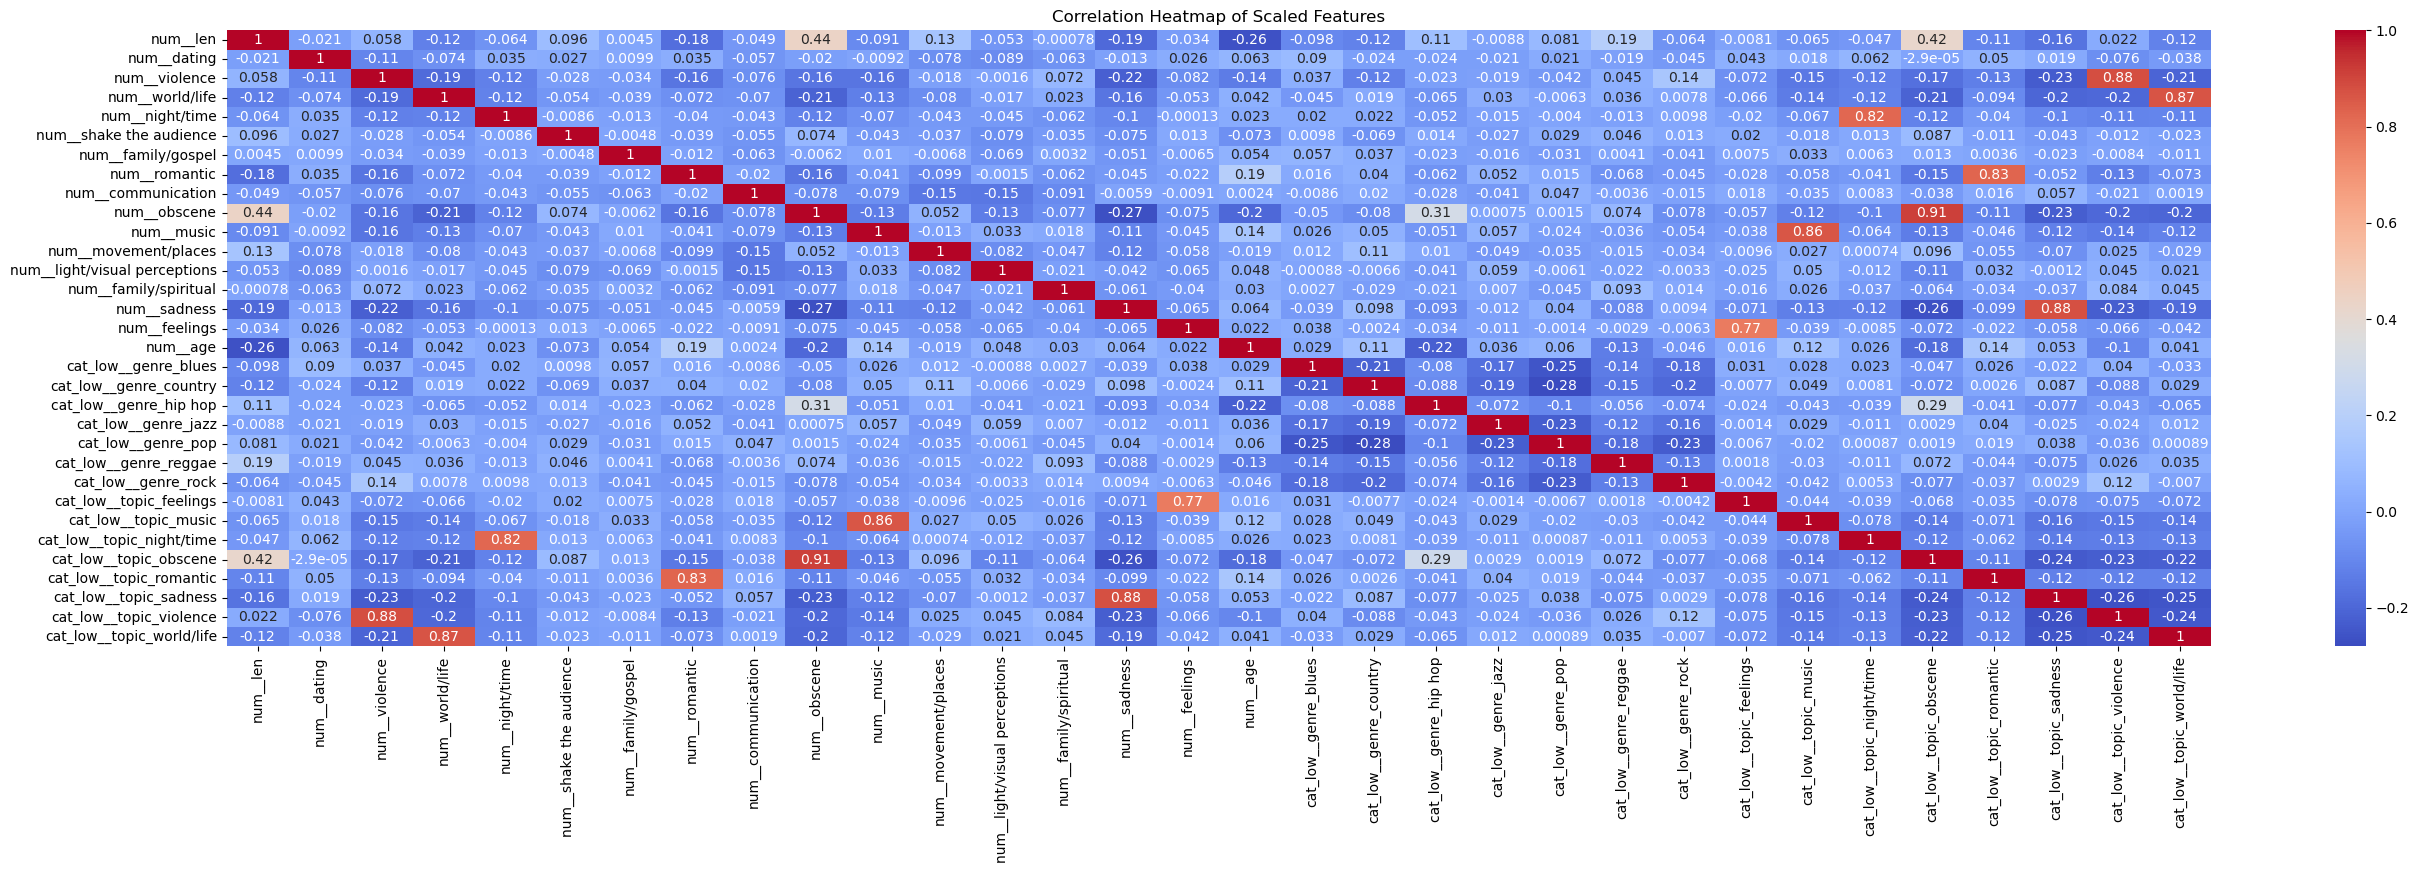

In [27]:
plt.figure(figsize=(32, 8))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Scaled Features')
plt.show()

In [29]:
df_processed.columns

Index(['num__len', 'num__dating', 'num__violence', 'num__world/life',
       'num__night/time', 'num__shake the audience', 'num__family/gospel',
       'num__romantic', 'num__communication', 'num__obscene', 'num__music',
       'num__movement/places', 'num__light/visual perceptions',
       'num__family/spiritual', 'num__sadness', 'num__feelings', 'num__age',
       'cat_low__genre_blues', 'cat_low__genre_country',
       'cat_low__genre_hip hop', 'cat_low__genre_jazz', 'cat_low__genre_pop',
       'cat_low__genre_reggae', 'cat_low__genre_rock',
       'cat_low__topic_feelings', 'cat_low__topic_music',
       'cat_low__topic_night/time', 'cat_low__topic_obscene',
       'cat_low__topic_romantic', 'cat_low__topic_sadness',
       'cat_low__topic_violence', 'cat_low__topic_world/life'],
      dtype='object')

In [31]:
# Removed topic columns to reduce multicollinearity 
drop_topic = ['cat_low__topic_feelings', 'cat_low__topic_music',
       'cat_low__topic_night/time', 'cat_low__topic_obscene',
       'cat_low__topic_romantic', 'cat_low__topic_sadness',
       'cat_low__topic_violence', 'cat_low__topic_world/life']
df_processed = df_processed.drop(columns=drop_topic)
df_processed.head()

,num__len,num__dating,num__violence,num__world/life,num__night/time,num__shake the audience,num__family/gospel,num__romantic,num__communication,num__obscene,...,num__sadness,num__feelings,num__age,cat_low__genre_blues,cat_low__genre_country,cat_low__genre_hip hop,cat_low__genre_jazz,cat_low__genre_pop,cat_low__genre_reggae,cat_low__genre_rock
0,0.474747,0.000475,0.064658,0.000320,0.000317,0.000631,0.089113,0.017884,0.408124,0.000311,...,0.387319,0.121944,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.252525,0.054442,0.098311,0.460738,0.001022,0.002010,0.049023,0.001062,0.001538,0.001003,...,0.001018,0.001038,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.116162,0.003830,0.002532,0.002578,0.002549,0.004999,0.004552,0.168293,0.387858,0.002501,...,0.002533,0.234876,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.267677,0.074077,0.001287,0.001307,0.001293,0.042672,0.002310,0.437267,0.001948,0.001269,...,0.229942,0.001313,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.237374,0.001635,0.001085,0.434056,0.001089,0.002142,0.001946,0.492444,0.001640,0.001069,...,0.069833,0.001106,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


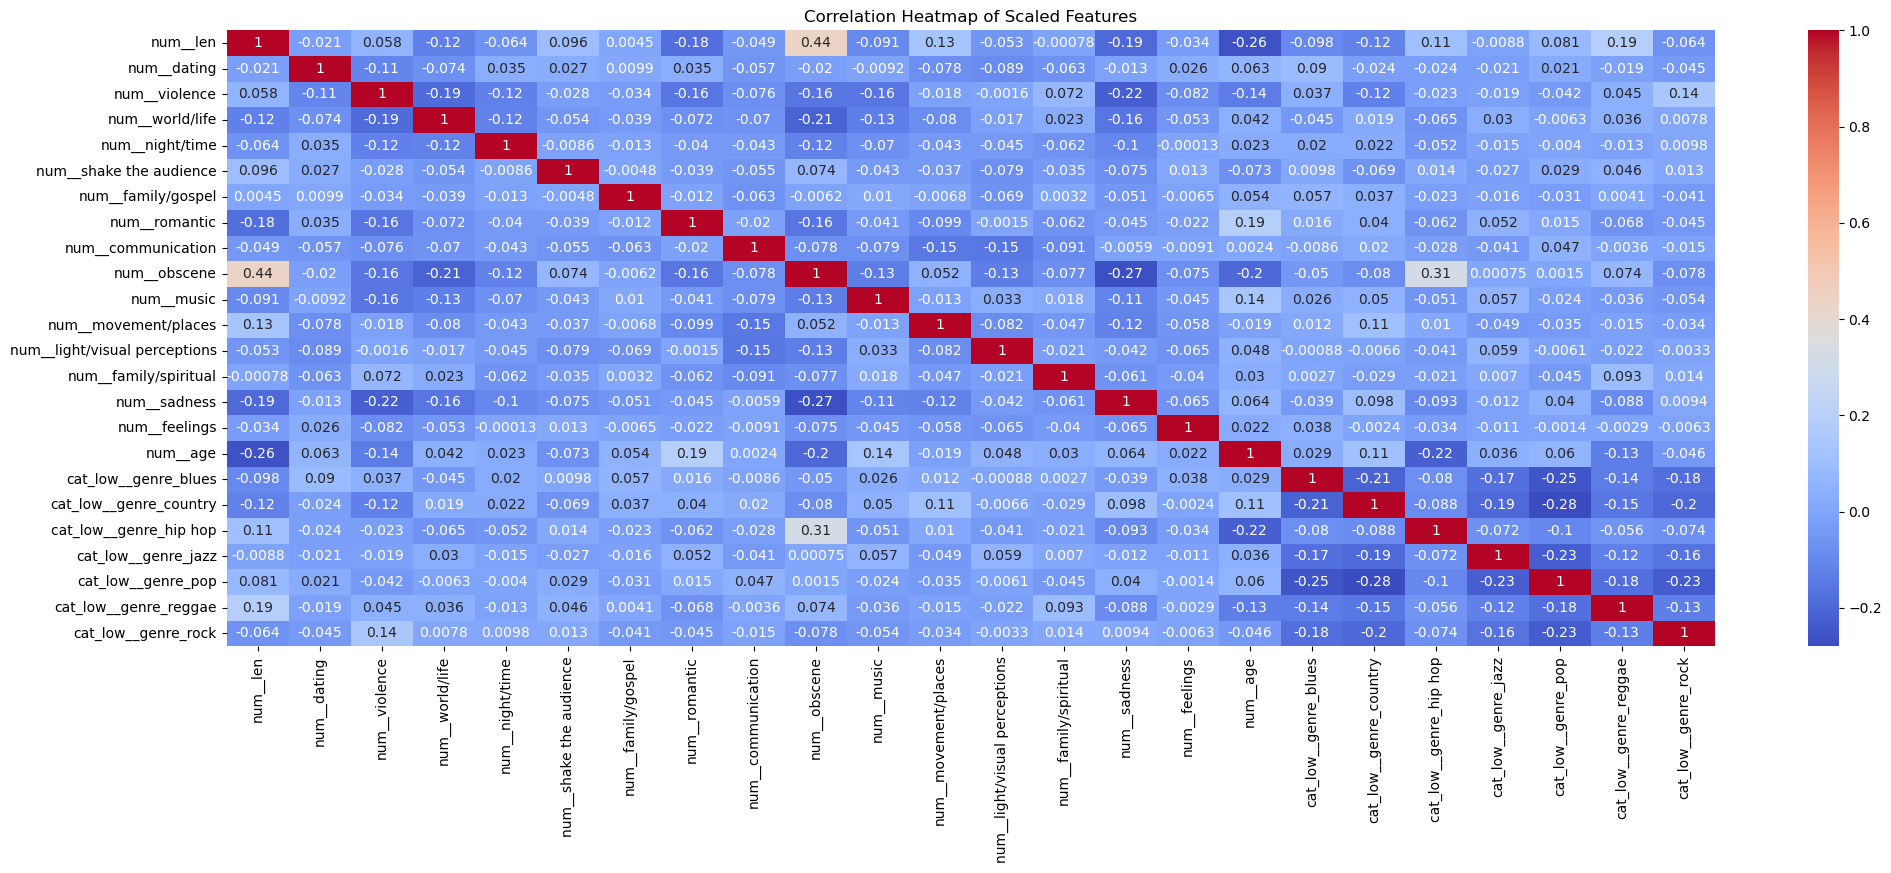

In [34]:
plt.figure(figsize=(24, 8))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Scaled Features')
plt.show()

In [39]:
df_processed.columns

Index(['num__len', 'num__dating', 'num__violence', 'num__world/life',
       'num__night/time', 'num__shake the audience', 'num__family/gospel',
       'num__romantic', 'num__communication', 'num__obscene', 'num__music',
       'num__movement/places', 'num__light/visual perceptions',
       'num__family/spiritual', 'num__sadness', 'num__feelings', 'num__age',
       'cat_low__genre_blues', 'cat_low__genre_country',
       'cat_low__genre_hip hop', 'cat_low__genre_jazz', 'cat_low__genre_pop',
       'cat_low__genre_reggae', 'cat_low__genre_rock'],
      dtype='object')

In [40]:
output_path = os.path.join('/Users/sa26/Documents/GitHub/Music-Recommendation-Algorithm/data/processed', 'processed_train.csv')
df_processed.to_csv(output_path, index=False)